In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from models.MLP import MLP, plot_training

In [2]:
df_data = pd.read_csv('../data/train.csv')
df_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [3]:
X = df_data.iloc[:,2:].values
species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1

In [4]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

## Test d'entrainement via une descente de gradiant 

In [5]:
model = MLP(X_train, t_train, X_test, t_test, num_epochs=500)
model.set_model(input_size=X_train.shape[1], output_size=t_train.shape[1], activation_function='relu')
model.set_optimizer(optim='SGD', lr=1e-2, reg=0)

In [6]:
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

Epoch 1/500, Loss: 4.60361, Accuracy: 1.15%
Epoch 2/500, Loss: 4.59637, Accuracy: 0.87%
Epoch 3/500, Loss: 4.59165, Accuracy: 1.01%
Epoch 4/500, Loss: 4.58822, Accuracy: 1.15%
Epoch 5/500, Loss: 4.58560, Accuracy: 1.15%
Epoch 6/500, Loss: 4.58351, Accuracy: 1.30%
Epoch 7/500, Loss: 4.58172, Accuracy: 1.30%
Epoch 8/500, Loss: 4.58007, Accuracy: 1.44%
Epoch 9/500, Loss: 4.57839, Accuracy: 1.44%
Epoch 10/500, Loss: 4.57659, Accuracy: 1.59%
Epoch 11/500, Loss: 4.57452, Accuracy: 2.02%
Epoch 12/500, Loss: 4.57190, Accuracy: 2.02%
Epoch 13/500, Loss: 4.56843, Accuracy: 2.16%
Epoch 14/500, Loss: 4.56348, Accuracy: 2.74%
Epoch 15/500, Loss: 4.55619, Accuracy: 3.03%
Epoch 16/500, Loss: 4.54464, Accuracy: 3.03%
Epoch 17/500, Loss: 4.52516, Accuracy: 3.17%
Epoch 18/500, Loss: 4.49050, Accuracy: 3.75%
Epoch 19/500, Loss: 4.42811, Accuracy: 3.32%
Epoch 20/500, Loss: 4.32978, Accuracy: 3.46%
Epoch 21/500, Loss: 4.21648, Accuracy: 2.74%
Epoch 22/500, Loss: 4.11591, Accuracy: 3.46%
Epoch 23/500, Loss:

In [7]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 81.82% sur les données test


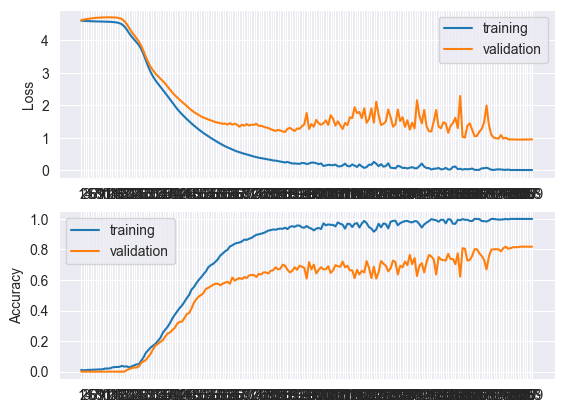

In [8]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

# Ajout d'un terme de régularisation

In [9]:
model.set_optimizer(optim='SGD', lr=1e-2, reg=1e-3)
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

Epoch 1/500, Loss: 4.60574, Accuracy: 0.72%
Epoch 2/500, Loss: 4.59833, Accuracy: 1.15%
Epoch 3/500, Loss: 4.59331, Accuracy: 0.87%
Epoch 4/500, Loss: 4.58980, Accuracy: 1.01%
Epoch 5/500, Loss: 4.58717, Accuracy: 1.01%
Epoch 6/500, Loss: 4.58516, Accuracy: 1.15%
Epoch 7/500, Loss: 4.58364, Accuracy: 1.30%
Epoch 8/500, Loss: 4.58241, Accuracy: 1.30%
Epoch 9/500, Loss: 4.58140, Accuracy: 1.30%
Epoch 10/500, Loss: 4.58050, Accuracy: 1.30%
Epoch 11/500, Loss: 4.57965, Accuracy: 1.30%
Epoch 12/500, Loss: 4.57883, Accuracy: 1.15%
Epoch 13/500, Loss: 4.57799, Accuracy: 1.30%
Epoch 14/500, Loss: 4.57708, Accuracy: 1.44%
Epoch 15/500, Loss: 4.57607, Accuracy: 1.73%
Epoch 16/500, Loss: 4.57484, Accuracy: 1.88%
Epoch 17/500, Loss: 4.57330, Accuracy: 2.31%
Epoch 18/500, Loss: 4.57133, Accuracy: 2.60%
Epoch 19/500, Loss: 4.56864, Accuracy: 2.74%
Epoch 20/500, Loss: 4.56483, Accuracy: 2.89%
Epoch 21/500, Loss: 4.55907, Accuracy: 3.03%
Epoch 22/500, Loss: 4.54999, Accuracy: 2.89%
Epoch 23/500, Loss:

In [10]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 67.00% sur les données test


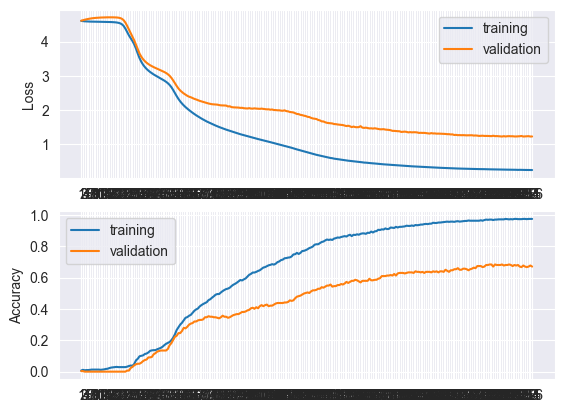

In [11]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

## Recherche des hyperparamètres

In [12]:
best_params, accuracy_historic = model.k_fold_cross_validation(X_train, t_train)

testing parameters: learning_rate = 1e-04,    regularization = 1e-03
K = 0, accuracy: 0.000
K = 1, accuracy: 0.007
K = 2, accuracy: 0.007
K = 3, accuracy: 0.000
K = 4, accuracy: 0.007
Best val accuracy: 0.004 | lr: 1e-04 | l2_reg: 1e-03
testing parameters: learning_rate = 1e-04,    regularization = 1e-04
K = 0, accuracy: 0.007
K = 1, accuracy: 0.007
K = 2, accuracy: 0.000
K = 3, accuracy: 0.000
K = 4, accuracy: 0.000
testing parameters: learning_rate = 1e-04,    regularization = 1e-05
K = 0, accuracy: 0.007
K = 1, accuracy: 0.000
K = 2, accuracy: 0.007
K = 3, accuracy: 0.007
K = 4, accuracy: 0.007
Best val accuracy: 0.006 | lr: 1e-04 | l2_reg: 1e-05
testing parameters: learning_rate = 1e-04,    regularization = 1e-06
K = 0, accuracy: 0.000
K = 1, accuracy: 0.014
K = 2, accuracy: 0.000
K = 3, accuracy: 0.007
K = 4, accuracy: 0.007
testing parameters: learning_rate = 1e-04,    regularization = 1e-07
K = 0, accuracy: 0.000
K = 1, accuracy: 0.000
K = 2, accuracy: 0.007
K = 3, accuracy: 0.0

In [13]:
best_params

(0.01, 1e-05)

### Apprentissage complet du modèle avec les meilleurs hyperparamètres trouvés

In [14]:
model.set_optimizer(optim='SGD', lr=best_params[0], reg=best_params[1])
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

Epoch 1/500, Loss: 4.60626, Accuracy: 1.01%
Epoch 2/500, Loss: 4.59831, Accuracy: 0.72%
Epoch 3/500, Loss: 4.59293, Accuracy: 0.87%
Epoch 4/500, Loss: 4.58911, Accuracy: 1.01%
Epoch 5/500, Loss: 4.58617, Accuracy: 1.01%
Epoch 6/500, Loss: 4.58384, Accuracy: 1.15%
Epoch 7/500, Loss: 4.58180, Accuracy: 1.15%
Epoch 8/500, Loss: 4.57993, Accuracy: 1.15%
Epoch 9/500, Loss: 4.57798, Accuracy: 1.30%
Epoch 10/500, Loss: 4.57585, Accuracy: 1.59%
Epoch 11/500, Loss: 4.57329, Accuracy: 1.73%
Epoch 12/500, Loss: 4.56995, Accuracy: 2.02%
Epoch 13/500, Loss: 4.56539, Accuracy: 2.31%
Epoch 14/500, Loss: 4.55879, Accuracy: 2.60%
Epoch 15/500, Loss: 4.54827, Accuracy: 3.03%
Epoch 16/500, Loss: 4.53063, Accuracy: 3.03%
Epoch 17/500, Loss: 4.49927, Accuracy: 3.17%
Epoch 18/500, Loss: 4.44131, Accuracy: 3.32%
Epoch 19/500, Loss: 4.34116, Accuracy: 4.18%
Epoch 20/500, Loss: 4.20501, Accuracy: 4.47%
Epoch 21/500, Loss: 4.05572, Accuracy: 5.05%
Epoch 22/500, Loss: 3.89839, Accuracy: 6.49%
Epoch 23/500, Loss:

In [15]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 66.67% sur les données test


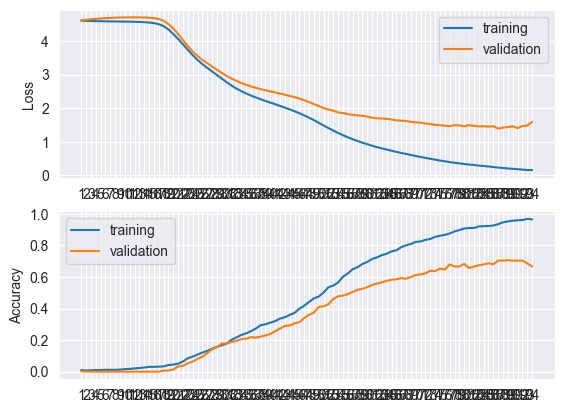

In [16]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

### Normalisation des données

In [17]:
df_data.iloc[:,2:].max()

margin1      0.087891
margin2      0.205080
margin3      0.156250
margin4      0.169920
margin5      0.111330
               ...   
texture60    0.578130
texture61    0.151370
texture62    0.375980
texture63    0.086914
texture64    0.141600
Length: 192, dtype: float64

Les données ne sont pas normalisées ce qui peut donner injustement plus de poids à certaines caractéristiques plutôt qu'à d'autre. Pour palier ce problème nous normalison nos données selon la normalisation min-max.

In [18]:
X = ((df_data.iloc[:,2:] - df_data.iloc[:,2:].min()) / (df_data.iloc[:,2:].max() - df_data.iloc[:,2:].min())).values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1
    
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [19]:
model.set_optimizer(optim='SGD', lr=1e-3, reg=1e-4)
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

Epoch 1/500, Loss: 4.59836, Accuracy: 0.87%
Epoch 2/500, Loss: 4.59469, Accuracy: 0.87%
Epoch 3/500, Loss: 4.59125, Accuracy: 0.87%
Epoch 4/500, Loss: 4.58784, Accuracy: 1.15%
Epoch 5/500, Loss: 4.58433, Accuracy: 1.30%
Epoch 6/500, Loss: 4.58059, Accuracy: 2.16%
Epoch 7/500, Loss: 4.57663, Accuracy: 3.46%
Epoch 8/500, Loss: 4.57237, Accuracy: 4.33%
Epoch 9/500, Loss: 4.56770, Accuracy: 4.04%
Epoch 10/500, Loss: 4.56241, Accuracy: 3.90%
Epoch 11/500, Loss: 4.55637, Accuracy: 3.46%
Epoch 12/500, Loss: 4.54937, Accuracy: 2.60%
Epoch 13/500, Loss: 4.54118, Accuracy: 2.45%
Epoch 14/500, Loss: 4.53143, Accuracy: 2.31%
Epoch 15/500, Loss: 4.51984, Accuracy: 2.60%
Epoch 16/500, Loss: 4.50608, Accuracy: 2.31%
Epoch 17/500, Loss: 4.48986, Accuracy: 3.03%
Epoch 18/500, Loss: 4.47124, Accuracy: 2.60%
Epoch 19/500, Loss: 4.45022, Accuracy: 2.45%
Epoch 20/500, Loss: 4.42687, Accuracy: 2.02%
Epoch 21/500, Loss: 4.40129, Accuracy: 1.88%
Epoch 22/500, Loss: 4.37360, Accuracy: 1.88%
Epoch 23/500, Loss:

In [20]:
print("Précision du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Précision du model de 92.59% sur les données test


Les performances du modèle sont grandement améliorées en normalisant les données.

In [21]:
best_params, accuracy_historic = model.k_fold_cross_validation(X_train, t_train)

testing parameters: learning_rate = 1e-04,    regularization = 1e-03
K = 0, accuracy: 0.353
K = 1, accuracy: 0.489
K = 2, accuracy: 0.345
K = 3, accuracy: 0.413
K = 4, accuracy: 0.246
Best val accuracy: 0.369 | lr: 1e-04 | l2_reg: 1e-03
testing parameters: learning_rate = 1e-04,    regularization = 1e-04
K = 0, accuracy: 0.266
K = 1, accuracy: 0.410
K = 2, accuracy: 0.489
K = 3, accuracy: 0.333
K = 4, accuracy: 0.326
testing parameters: learning_rate = 1e-04,    regularization = 1e-05
K = 0, accuracy: 0.410
K = 1, accuracy: 0.353
K = 2, accuracy: 0.237
K = 3, accuracy: 0.348
K = 4, accuracy: 0.333
testing parameters: learning_rate = 1e-04,    regularization = 1e-06
K = 0, accuracy: 0.317
K = 1, accuracy: 0.374
K = 2, accuracy: 0.367
K = 3, accuracy: 0.478
K = 4, accuracy: 0.420
Best val accuracy: 0.391 | lr: 1e-04 | l2_reg: 1e-06
testing parameters: learning_rate = 1e-04,    regularization = 1e-07
K = 0, accuracy: 0.504
K = 1, accuracy: 0.367
K = 2, accuracy: 0.345
K = 3, accuracy: 0.3

In [27]:
accuracy_historic

array([[0.36929413, 0.36497758, 0.33623188, 0.39122094, 0.40548431,
        0.37787509, 0.35051611],
       [0.90621416, 0.9003545 , 0.90186633, 0.90324262, 0.91630695,
        0.9322177 , 0.91200083],
       [0.92776561, 0.94946304, 0.93652382, 0.94226879, 0.93219685,
        0.94804504, 0.93800438],
       [0.01156292, 0.01011365, 0.02740069, 0.01439892, 0.00578668,
        0.01298092, 0.0115525 ]])

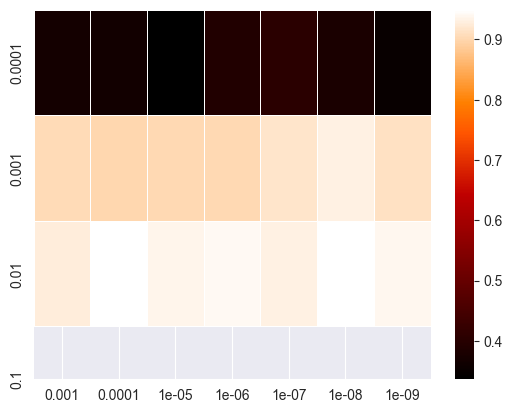

In [26]:
ax = sns.heatmap(accuracy_historic[:-1], linewidths=0.5, cmap='gist_heat', 
                 xticklabels=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9], 
                 yticklabels=[1e-4, 1e-3, 1e-2, 1e-1])

In [22]:
best_params

(0.01, 0.0001)

### Apprentissage global avec les meilleurs hyperparamètres

In [23]:
model.set_optimizer(optim='SGD', lr=best_params[0], reg=best_params[1])
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

Epoch 1/500, Loss: 4.59418, Accuracy: 1.44%
Epoch 2/500, Loss: 4.53476, Accuracy: 2.45%
Epoch 3/500, Loss: 4.31563, Accuracy: 3.17%
Epoch 4/500, Loss: 3.83582, Accuracy: 7.94%
Epoch 5/500, Loss: 3.23243, Accuracy: 17.89%
Epoch 6/500, Loss: 2.49604, Accuracy: 31.46%
Epoch 7/500, Loss: 1.81342, Accuracy: 45.60%
Epoch 8/500, Loss: 1.28805, Accuracy: 59.45%
Epoch 9/500, Loss: 0.86925, Accuracy: 74.17%
Epoch 10/500, Loss: 0.58488, Accuracy: 82.97%
Epoch 11/500, Loss: 0.39765, Accuracy: 90.04%
Epoch 12/500, Loss: 0.29039, Accuracy: 92.78%
Epoch 13/500, Loss: 0.18373, Accuracy: 95.82%
Epoch 14/500, Loss: 0.17202, Accuracy: 96.83%
Epoch 15/500, Loss: 0.11869, Accuracy: 97.40%
Epoch 16/500, Loss: 0.14036, Accuracy: 97.84%
Epoch 17/500, Loss: 0.08947, Accuracy: 98.56%
Epoch 18/500, Loss: 0.05700, Accuracy: 99.13%
Epoch 19/500, Loss: 0.04896, Accuracy: 99.28%
Epoch 20/500, Loss: 0.15560, Accuracy: 96.25%
Epoch 21/500, Loss: 0.04409, Accuracy: 99.71%
Epoch 22/500, Loss: 0.04926, Accuracy: 99.13%
E

In [24]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 93.60% sur les données test


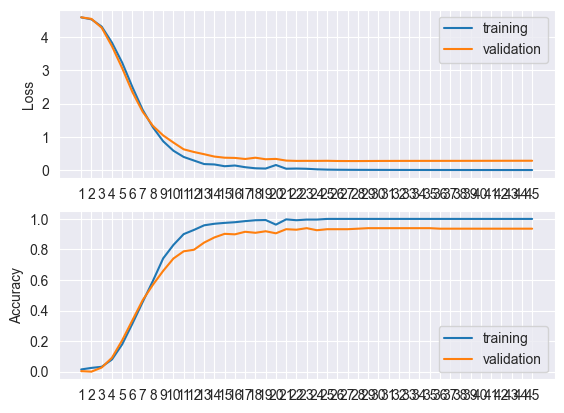

In [25]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)